In [1]:
import numpy as np
import pandas as pd
from pymc_extras.statespace.models import structural as st

import pymc as pm
import arviz as az
import pytensor.tensor as pt

import matplotlib.pyplot as plt

In [2]:
rng = np.random

In [3]:
def simulate_local_level_with_exog(
    n_endog: int = 1,
    time_steps: int = 100,
    mu0: float = 0.0,
    sigma_eta: float = 1.0,
    sigma_eps: float = 0.5,
    beta1: float = 2.0,
    beta2: float = -1.5,
    seed: int | None = None,
):
    """
    Simulates a local level model with exogenous variables.

    Parameters
    ----------
    n_endog: int
        The number of series to simulate
    time_steps: int
        The length of the time-series to simulate
    mu0: float
        The initial state
    sigma_eta: float
        The level innovations standard deviation
    sigma_eps: float
        The observations standard deviation
    beta1: float
        The weight of the binary exogenous variable
    beta2: float
        The weight of the continuous exogenous variable
    seed: int
        Random generator seed for reproducibility

    Returns
    -------
    ys: dict[str, float]
        n_endog number of observations
    mu: float
        latent state
    x1: int
        binary exogenous observations
    x2: float
        continuous exogenous observations
    """
    if seed is not None:
        np.random.seed(seed)

    # init state and observation vectors
    mu = np.zeros(time_steps)
    y = np.zeros(time_steps)

    # initial state
    mu[0] = mu0

    # simulate exogenous variables
    # binary variable
    x1 = np.random.binomial(1, 0.2, size=time_steps)

    # continous variable
    x2 = np.random.normal(0, 1, size=time_steps)

    # simulate latent state (local level)
    for t in range(1, time_steps):
        mu[t] = mu[t - 1] + np.random.normal(0, sigma_eta)

    # simulate observations
    ys = {
        f"y{i+1}": mu + beta1 * x1 + beta2 * x2 + np.random.normal(0, sigma_eps, size=time_steps)
        for i in range(n_endog)
    }

    return ys, mu, x1, x2

In [4]:
# Simulate
T = 100
true_sigma_eta = 0.3
true_sigma_eps = 0.6
true_beta1 = 3.0
true_beta2 = -1.0
ys, mu, x1, x2 = simulate_local_level_with_exog(
    n_endog=3,
    time_steps=T,
    mu0=0,
    sigma_eta=true_sigma_eta,
    sigma_eps=true_sigma_eps,
    beta1=true_beta1,
    beta2=true_beta2,
    seed=42,
)

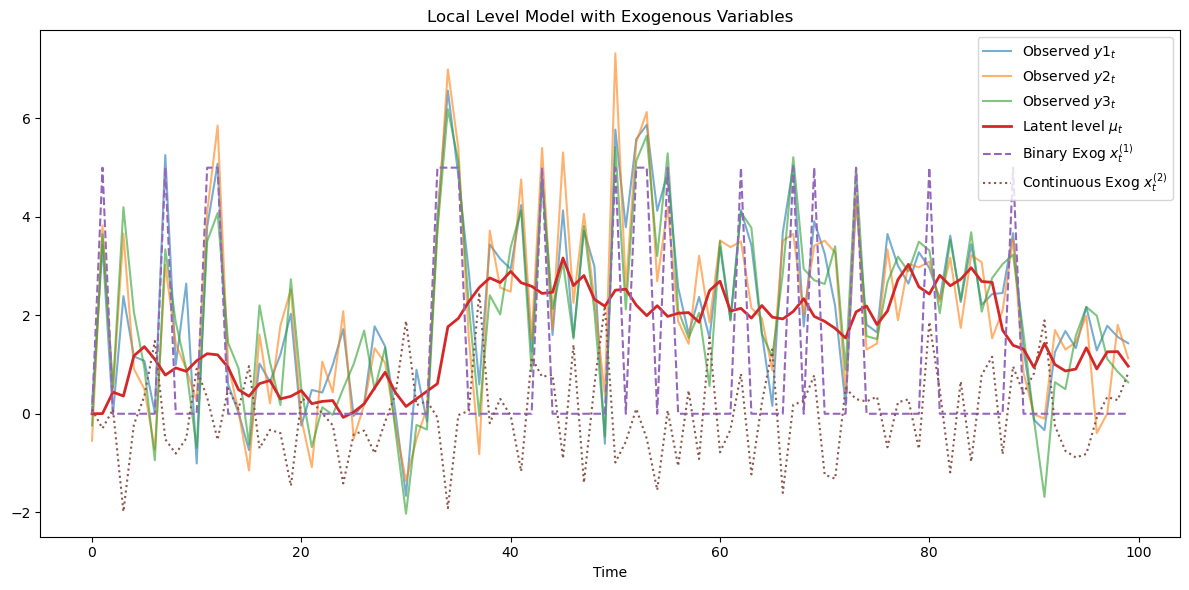

In [5]:
y = ys["y1"]

# Plot
plt.figure(figsize=(12, 6))
for k, vy in ys.items():
    plt.plot(vy, label=f"Observed ${k}_t$", alpha=0.6)
plt.plot(mu, label="Latent level $\\mu_t$", linewidth=2)
plt.plot(x1 * 5, label="Binary Exog $x^{(1)}_t$", linestyle="--")  # need to blow up to see it
plt.plot(x2, label="Continuous Exog $x^{(2)}_t$", linestyle=":")
plt.legend()
plt.title("Local Level Model with Exogenous Variables")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [6]:
exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1"],
)
exog.build()

                            Model Requirements                             
                                                                           
  Variable    Shape       Constraints                          Dimensions  
 ───────────────────────────────────────────────────────────────────────── 
  beta_exog   (2,)                                        ('exog_state',)  
  P0          (2, 2)      Positive semi-definite   ('state', 'state_aux')  
                                                                           
  data_exog   (None, 2)   pm.Data                  ('time', 'exog_state')  
                                                                           
These parameters should be assigned priors inside a PyMC model block before
                calling the build_statespace_graph method.                 

In [7]:
exog.coords

{'exog_state': ['x1', 'x2'],
 'exog_endog': ['y1'],
 'state': ['x1', 'x2'],
 'state_aux': ['x1', 'x2'],
 'observed_state': ['y1'],
 'observed_state_aux': ['y1'],
 'shock': ['x1', 'x2'],
 'shock_aux': ['x1', 'x2']}

# Quick and dirty test

In [30]:
level_trend = st.LevelTrendComponent(
    order=1, innovations_order=[1], name="level_trend", observed_state_names=["y1", "y2", "y3"]
)

exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1", "y2", "y3"],
)

ss_mod = (level_trend + exog).build(mode="JAX")

                                  Model Requirements                                   
                                                                                       
  Variable        Shape       Constraints                                  Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────── 
  initial_trend   (3, 1)                               ('trend_endog', 'trend_state')  
  sigma_trend     (3, 1)      Positive                 ('trend_endog', 'trend_shock')  
  beta_exog       (3, 2)                                 ('exog_endog', 'exog_state')  
  P0              (9, 9)      Positive semi-definite           ('state', 'state_aux')  
                                                                                       
  data_exog       (None, 2)   pm.Data                          ('time', 'exog_state')  
                                                                                       
These parameters should be assigned priors inside a PyMC model block before calling the
                            build_statespace_graph method.                             

In [31]:
with pm.Model(coords=ss_mod.coords) as level_trend_exog_model:
    # Data container
    data_exog = pm.Data("data_exog", np.vstack((x1, x2)).T, dims=("time", "exog_state"))

    # Initial process covariance matrix
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=4, dims="state")
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=("state", "state_aux"))

    # Initial local level trend
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1, dims=("trend_endog", "trend_state"))

    # Local level innovations sigma
    sigma_trend = pm.HalfNormal("sigma_trend", 1, dims=("trend_endog", "trend_shock"))

    # exogenous variable parameter priors
    beta_exog = pm.Normal("beta_exog", 0, 5, dims=("exog_endog", "exog_state"))

    ss_mod.build_statespace_graph(np.vstack((ys["y1"], ys["y2"], ys["y3"])).T)

/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [32]:
with level_trend_exog_model:
    idata = pm.sample(
        nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "JAX", "gradient_backend": "JAX"}
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,16,0.53,7
,2000,7,0.53,7
,2000,6,0.51,7
,2000,18,0.53,7


In [33]:
az.summary(idata, var_names=["beta_exog", "sigma_trend"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta_exog[y1, x1]",2.928,0.678,1.520,4.147,0.012,0.013,3566.0,2688.0,1.0
"beta_exog[y1, x2]",-0.984,0.679,-2.326,0.322,0.012,0.014,3460.0,2694.0,1.0
"beta_exog[y2, x1]",2.997,0.727,1.588,4.421,0.013,0.015,3491.0,2196.0,1.0
"beta_exog[y2, x2]",-1.043,0.690,-2.278,0.396,0.011,0.016,3927.0,2385.0,1.0
"beta_exog[y3, x1]",2.768,0.725,1.393,4.133,0.013,0.018,3402.0,2262.0,1.0
"beta_exog[y3, x2]",-0.921,0.693,-2.171,0.483,0.012,0.014,3730.0,2390.0,1.0
"sigma_trend[y1, level]",0.755,0.052,0.657,0.856,0.001,0.001,6995.0,2715.0,1.0
"sigma_trend[y2, level]",0.924,0.070,0.797,1.058,0.001,0.001,6383.0,2770.0,1.0
"sigma_trend[y3, level]",0.846,0.062,0.739,0.964,0.001,0.001,5642.0,3208.0,1.0


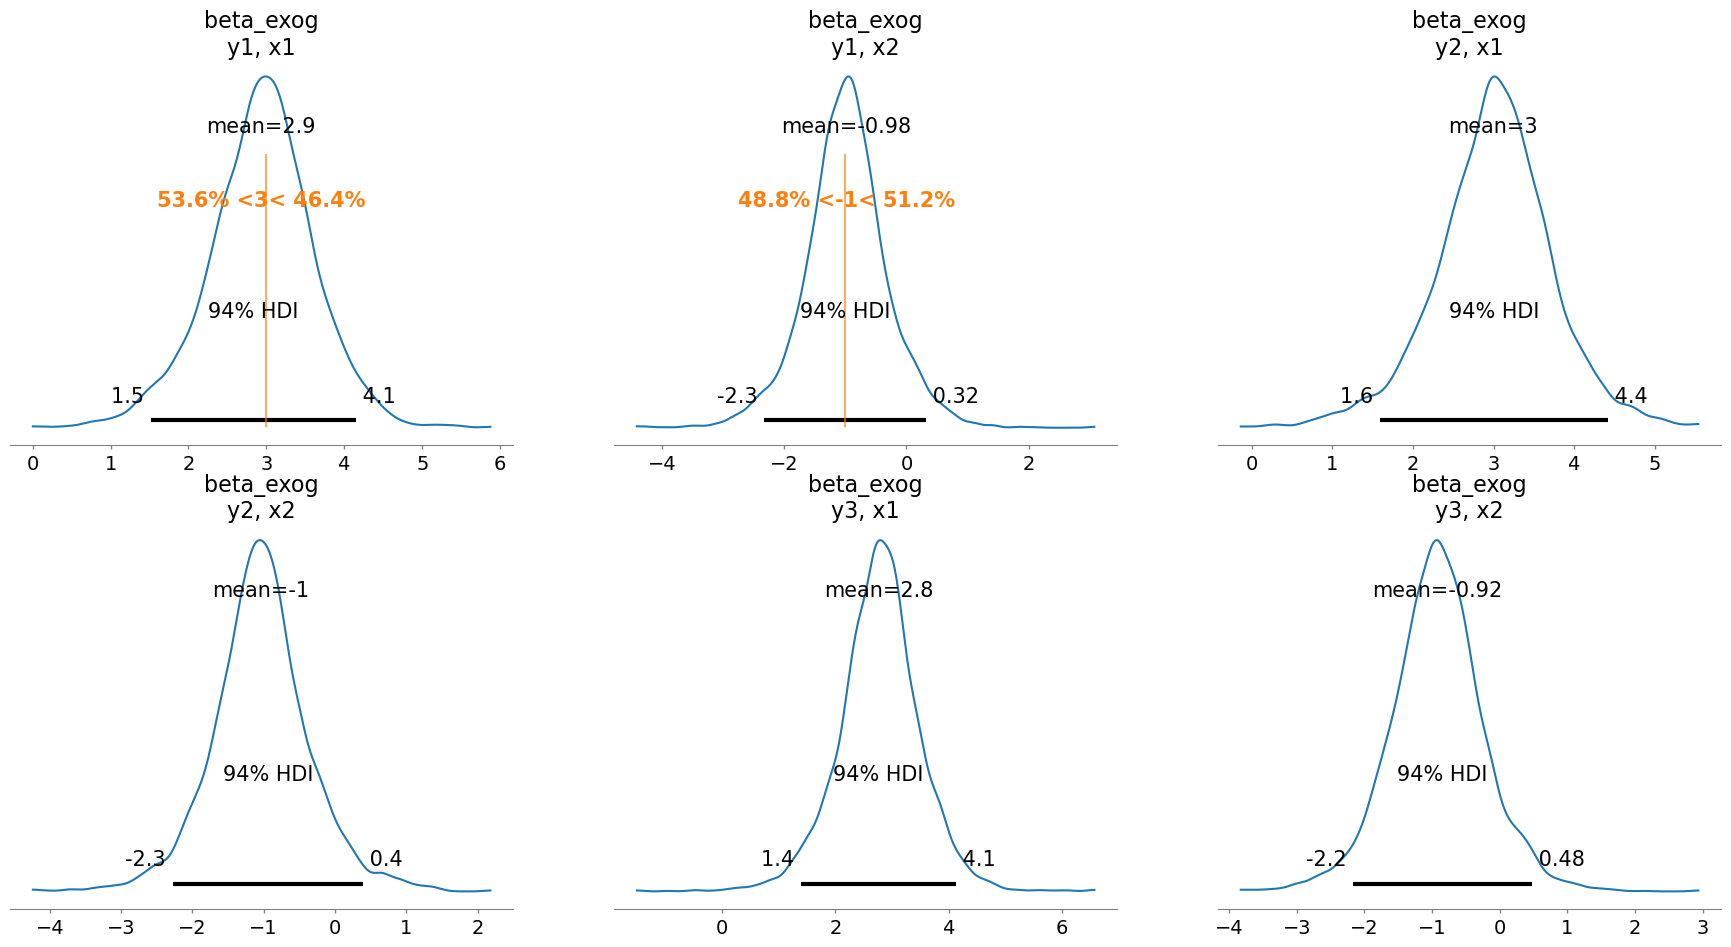

In [34]:
az.plot_posterior(
    idata,
    var_names="beta_exog",
    ref_val={
        "beta_exog": [
            {"exog_endog": "y1", "exog_state": "x1", "ref_val": true_beta1},
            {"exog_endog": "y1", "exog_state": "x2", "ref_val": true_beta2},
        ]
    },
);

In [35]:
idata_forecast = ss_mod.forecast(idata=idata, periods=10, scenario=np.vstack((x1, x2)).T[-10:])

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
/Users/dekermanjian/Desktop/Open_Source_Contributions/pymc-extras/pymc_extras/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/opt/miniconda3/envs/pymc-extras-test/lib/python3.12/site-packages/pytensor/link/jax/linker.py:32: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x358DD5D20>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


Output()

In [36]:
y1_forecast = idata_forecast.forecast_observed.sel(observed_state="y1")

In [37]:
y1_hdi = az.hdi(idata_forecast.forecast_observed.sel(observed_state="y1"))

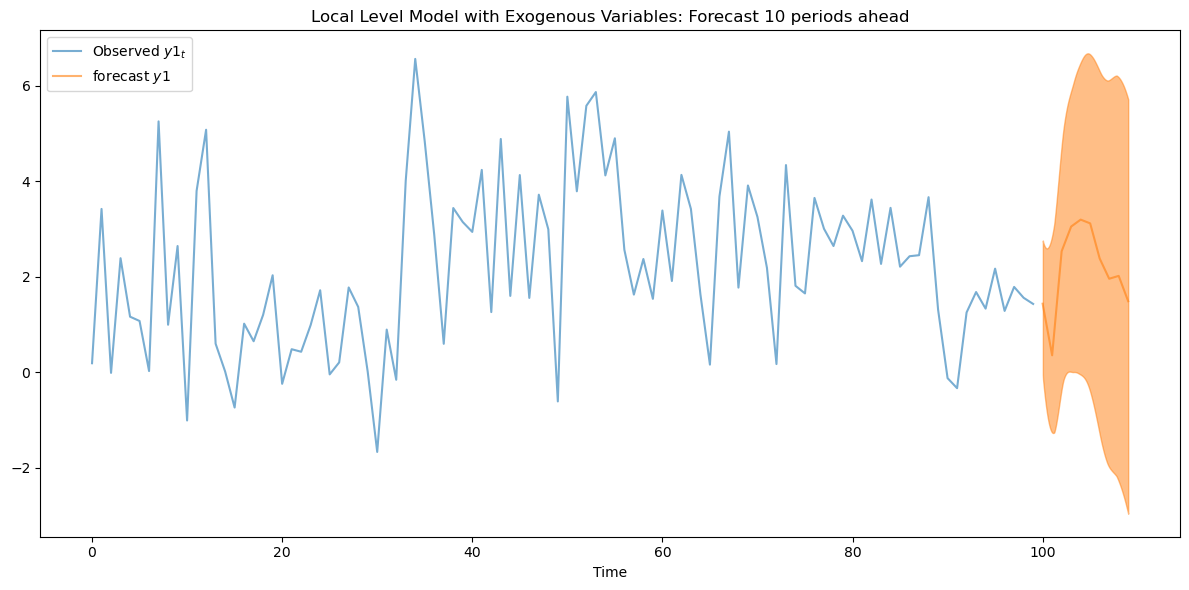

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(ys["y1"], label=f"Observed $y1_t$", alpha=0.6)
az.plot_hdi(x=np.arange(100, 110), hdi_data=y1_hdi)
plt.plot(
    np.arange(100, 110), y1_forecast.mean(("chain", "draw")), label=f"forecast $y1$", alpha=0.6
)

plt.legend()
plt.title("Local Level Model with Exogenous Variables: Forecast 10 periods ahead")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Need to test with missing data

In [ ]:
def impose_missingness(
    X: np.ndarray,
    total_missing_percent: float = 0.2,
    mcar_ratio: float = 0.33,
    mar_ratio: float = 0.33,
    mnar_ratio: float = 0.34,
    mar_features: list | None = None,
    mnar_features: list | None = None,
    seed: int | None = None,
):
    """
    Imposes missingness according to specified missing mechanisms MCAR, MAR, and MNAR

    Parameters
    ----------
    X: np.ndarray
        The matrix to impose missingness into
    total_missing_percent: float
        The percentage of total missingness to impose
    mcar_ratio: float
        The ratio of MCAR missingness to impose
    mar_ratio: float
        The ration of MAR missingness to impose
    mnar_ratio: float
        The ratio of MNAR missingness to impose
    mar_features: list|None
        The column index of the MAR features to condition on
    mnar_features: list|None
        The column index of the MNAR features to impose MNAR missingness
    seed: int|None
        The seed for reproducibility

    Returns
    -------
    X_missing: np.ndarray
        The original matrix with imposed missingness
    missing_mask: np.ndarray
        The missing mask that corresponds to the imposed missing values
    """
    if mar_features is None and mar_ratio != 0.0:
        raise ValueError(
            "If you want to impose MAR missing values you must set the index of the MAR variable(s) using `mar_features` otherwise set `mar_ratio = 0`"
        )

    if mar_features and mar_ratio == 0.0:
        raise ValueError("Pass `mar_features=None` if you do not wish to impose MAR missingness.")

    if mnar_features is None and mnar_ratio != 0.0:
        raise ValueError(
            "If you want to impose MNAR missing values you must set the index of the MNAR variable(s) using `mnar_features` otherwise set `mnar_ratio = 0`"
        )

    if mnar_features and mnar_ratio == 0.0:
        raise ValueError("Pass `mnar_features=None` if you do not wish to impose MNAR missingness.")

    assert np.isclose(mcar_ratio + mar_ratio + mnar_ratio, 1.0), "Ratios must sum to 1"

    rng = np.random.default_rng(seed)
    X_missing = X.copy()
    n_rows, n_cols = X.shape
    total_cells = n_rows * n_cols
    n_missing = int(total_cells * total_missing_percent)

    # Number of missing cells by type
    n_mcar = int(n_missing * mcar_ratio)
    n_mar = int(n_missing * mar_ratio)
    n_mnar = n_missing - n_mcar - n_mar  # ensures total = n_missing

    missing_mask = np.zeros_like(X_missing, dtype=bool)

    # --- MCAR: Randomly pick cells to be missing
    all_indices = np.argwhere(~missing_mask)
    mcar_indices = all_indices[rng.choice(len(all_indices), size=n_mcar, replace=False)]
    for i, j in mcar_indices:
        missing_mask[i, j] = True

    # --- MAR: Missingness in other columns depending on mar_features
    if mar_features:
        mar_features = list(mar_features)
        mar_cond_scores = np.zeros(n_rows)
        for f in mar_features:
            col = X[:, f]
            norm_col = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-16)
            mar_cond_scores += norm_col
        mar_probs = mar_cond_scores / (mar_cond_scores.sum() + 1e-16)

        mar_rows = rng.choice(n_rows, size=n_mar, p=mar_probs, replace=True)
        mar_cols = rng.choice([c for c in range(n_cols) if c not in mar_features], size=n_mar)
        for i, j in zip(mar_rows, mar_cols):
            missing_mask[i, j] = True

    # --- MNAR: Missing values depend on values in the same columns set by mnar_features
    if mnar_features:
        mnar_features = list(mnar_features)
        mnar_rows_all = []
        mnar_cols_all = []
        n_mnar_per_feature = n_mnar // len(mnar_features)
        for f in mnar_features:
            col = X[:, f]
            norm_col = (col - np.min(col)) / (np.max(col) - np.min(col) + 1e-16)
            mnar_probs = norm_col / (norm_col.sum() + 1e-16)
            mnar_rows = rng.choice(n_rows, size=n_mnar_per_feature, p=mnar_probs, replace=True)
            mnar_rows_all.extend(mnar_rows)
            mnar_cols_all.extend([f] * n_mnar_per_feature)

        # Adjust if rounding caused mismatch
        while len(mnar_rows_all) < n_mnar:
            mnar_rows_all.append(rng.integers(0, n_rows))
            mnar_cols_all.append(mnar_features[0])

        for i, j in zip(mnar_rows_all, mnar_cols_all):
            missing_mask[i, j] = True

    # Apply mask
    X_missing[missing_mask] = np.nan
    return X_missing, missing_mask

In [6]:
X = np.vstack((x1, x2, ys["y1"], ys["y2"], ys["y3"])).T

In [7]:
X_miss, mask = impose_missingness(
    X,
    missing_rate=0.2,
    mcar_ratio=0.3,
    mar_ratio=0.4,
    mnar_ratio=0.3,
    mar_features=[
        0,
    ],
    mnar_features=[
        2,
    ],
    random_state=31324,
)

print("Missing values introduced:", np.isnan(X_miss).sum())

Missing values introduced: 79


In [57]:
level_trend = st.LevelTrendComponent(
    order=1, innovations_order=[1], name="level_trend", observed_state_names=["y1", "y2", "y3"]
)

exog = st.RegressionComponent(
    name="exog",
    k_exog=2,
    innovations=False,
    state_names=["x1", "x2"],
    observed_state_names=["y1", "y2", "y3"],
)

ss_mod = (level_trend + exog).build(mode="JAX")

                                  Model Requirements                                   
                                                                                       
  Variable        Shape       Constraints                                  Dimensions  
 ───────────────────────────────────────────────────────────────────────────────────── 
  initial_trend   (3, 1)                               ('trend_endog', 'trend_state')  
  sigma_trend     (3, 1)      Positive                 ('trend_endog', 'trend_shock')  
  beta_exog       (3, 2)                                 ('exog_endog', 'exog_state')  
  P0              (9, 9)      Positive semi-definite           ('state', 'state_aux')  
                                                                                       
  data_exog       (None, 2)   pm.Data                          ('time', 'exog_state')  
                                                                                       
These parameters should be assigned priors inside a PyMC model block before calling the
                            build_statespace_graph method.                             

## Need to make some adjustments to state space to allow passing of pm.Deterministic exogenous variables.

In [63]:
with pm.Model(coords=ss_mod.coords) as level_trend_exog_model:
    # Data container
    data_exog = pm.Data("data_exog", X_miss[:, :2], dims=("time", "exog_state"))

    # Initial process covariance matrix
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=4, dims="state")
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=("state", "state_aux"))

    # Initial local level trend
    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1, dims=("trend_endog", "trend_state"))

    # Local level innovations sigma
    sigma_trend = pm.HalfNormal("sigma_trend", 1, dims=("trend_endog", "trend_shock"))

    # exogenous variable parameter priors
    beta_exog = pm.Normal("beta_exog", 0, 5, dims=("exog_endog", "exog_state"))

    ss_mod.build_statespace_graph(X_miss[:, 2:])

NotImplementedError: Masked arrays or arrays with `nan` entries are not supported. Pass them directly to `observed` if you want to trigger auto-imputation